<b> Goal: </b> Analyze the Lebanese COVID-19 data and create a time series model to make predictions about various information related to COVID-19.

<b> Overview </b>
1) 
1. <a href="#1-1"> Import the necessary packages </a>
2. <a href="#1-2"> Retrieve the data </a>

2)
1. <a href="#2-1"> Explore the features </a>
2. <a href="#2-2"> Feature Selection </a>

3)
1. <a href="#3-1"> Visualize the series </a>
2. <a href="#3-2"> Test if the Series are Stationary </a>

4)
1. <a href="#4-1"> Split the data to train and test </a>
2. <a href="#4-2"> Modelling with AR (auto regressive) model. </a>

### 1.1. <p id="1-1">Import the necessary packages</p>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from covid19dh import covid19
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'figure.figsize': (8, 3), 'figure.dpi': 120})

### 1.2. <p id='1-2'>Retrieve the data of Lebanon</p>

In [2]:
leb, src = covid19('LB', verbose=False)
leb.tail()

,id,date,vaccines,tests,confirmed,recovered,deaths,hosp,vent,icu,...,administrative_area_level_3,latitude,longitude,key,key_alpha_2,key_numeric,key_local,key_google_mobility,key_apple_mobility,key_jhu_csse
64386,LBN,2021-10-09,3020555.0,NaN,629561.0,NaN,8382.0,NaN,NaN,NaN,...,NaN,33.8547,35.8623,NaN,NaN,NaN,NaN,LB,NaN,NaN
64387,LBN,2021-10-10,3026121.0,NaN,630180.0,NaN,8385.0,NaN,NaN,NaN,...,NaN,33.8547,35.8623,NaN,NaN,NaN,NaN,LB,NaN,NaN
64388,LBN,2021-10-11,3028487.0,NaN,630382.0,NaN,8389.0,NaN,NaN,NaN,...,NaN,33.8547,35.8623,NaN,NaN,NaN,NaN,LB,NaN,NaN
64389,LBN,2021-10-12,3034963.0,NaN,630950.0,NaN,8394.0,NaN,NaN,NaN,...,NaN,33.8547,35.8623,NaN,NaN,NaN,NaN,LB,NaN,NaN
64390,LBN,2021-10-13,3081683.0,NaN,631642.0,NaN,8400.0,NaN,NaN,NaN,...,NaN,33.8547,35.8623,NaN,NaN,NaN,NaN,LB,NaN,NaN


### 2.1 <p id='2-1'>Explore the features</p>

In [3]:
leb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 631 entries, 63760 to 64390
Data columns (total 40 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   id                                   631 non-null    object        
 1   date                                 631 non-null    datetime64[ns]
 2   vaccines                             226 non-null    float64       
 3   tests                                26 non-null     float64       
 4   confirmed                            601 non-null    float64       
 5   recovered                            519 non-null    float64       
 6   deaths                               583 non-null    float64       
 7   hosp                                 0 non-null      float64       
 8   vent                                 0 non-null      float64       
 9   icu                                  0 non-null      float64       
 10  populati

#### Date has a valid type and doesn't need any conversions

In [4]:
leb.set_index('date', inplace=True)  # set date as index
leb.tail()

,id,vaccines,tests,confirmed,recovered,deaths,hosp,vent,icu,population,...,administrative_area_level_3,latitude,longitude,key,key_alpha_2,key_numeric,key_local,key_google_mobility,key_apple_mobility,key_jhu_csse
date,,,,,,,,,,,,,,,,,,,,,
2021-10-09,LBN,3020555.0,NaN,629561.0,NaN,8382.0,NaN,NaN,NaN,6848925,...,NaN,33.8547,35.8623,NaN,NaN,NaN,NaN,LB,NaN,NaN
2021-10-10,LBN,3026121.0,NaN,630180.0,NaN,8385.0,NaN,NaN,NaN,6848925,...,NaN,33.8547,35.8623,NaN,NaN,NaN,NaN,LB,NaN,NaN
2021-10-11,LBN,3028487.0,NaN,630382.0,NaN,8389.0,NaN,NaN,NaN,6848925,...,NaN,33.8547,35.8623,NaN,NaN,NaN,NaN,LB,NaN,NaN
2021-10-12,LBN,3034963.0,NaN,630950.0,NaN,8394.0,NaN,NaN,NaN,6848925,...,NaN,33.8547,35.8623,NaN,NaN,NaN,NaN,LB,NaN,NaN
2021-10-13,LBN,3081683.0,NaN,631642.0,NaN,8400.0,NaN,NaN,NaN,6848925,...,NaN,33.8547,35.8623,NaN,NaN,NaN,NaN,LB,NaN,NaN


#### Make sure the date is consistent

In [5]:
leb.resample('D').asfreq().index.isnull().sum()

0

The date is consistent.

### 2.2. <p id='2-2'> Feature Selection </p>

The columns needed for analysis are `confirmed`, `recovered` and `deaths`

In [6]:
leb_features = leb[['confirmed', 'recovered', 'deaths']]
leb_features.tail()

,confirmed,recovered,deaths
date,,,
2021-10-09,629561.0,NaN,8382.0
2021-10-10,630180.0,NaN,8385.0
2021-10-11,630382.0,NaN,8389.0
2021-10-12,630950.0,NaN,8394.0
2021-10-13,631642.0,NaN,8400.0


#### The values are commulative sums whereas the needed data should be daily new observations

In [7]:
for col in leb_features.columns:  # transform the data to daily to new observations
    leb_features[col].iloc[1:] = [leb_features[col][i] - leb_features[col][i-1] for i in range(1, len(leb_features))]
                                                                        
leb_features

,confirmed,recovered,deaths
date,,,
2020-01-22,NaN,NaN,NaN
2020-01-23,NaN,NaN,NaN
2020-01-24,NaN,NaN,NaN
2020-01-25,NaN,NaN,NaN
2020-01-26,NaN,NaN,NaN
...,...,...,...
2021-10-09,680.0,NaN,3.0
2021-10-10,619.0,NaN,3.0
2021-10-11,202.0,NaN,4.0


The data is carefully collected and at the starting dates the values are NaN because there was no covid19 infections so these NaN values should be zero.

In [8]:
leb_features = leb_features.fillna(0)
leb_features

,confirmed,recovered,deaths
date,,,
2020-01-22,0.0,0.0,0.0
2020-01-23,0.0,0.0,0.0
2020-01-24,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0
2020-01-26,0.0,0.0,0.0
...,...,...,...
2021-10-09,680.0,0.0,3.0
2021-10-10,619.0,0.0,3.0
2021-10-11,202.0,0.0,4.0


In [9]:
leb_features.describe()

,confirmed,recovered,deaths
count,631.000000,631.000000,631.000000
mean,1001.015848,852.063391,13.310618
std,1170.976862,1432.915551,22.896493
min,0.000000,0.000000,0.000000
25%,26.000000,0.000000,0.000000
50%,595.000000,46.000000,5.000000
75%,1513.500000,1229.000000,14.500000
max,6154.000000,12635.000000,351.000000


### 3.1. <p id='3-1'> Visualize the Series </p>

In [10]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel=None, dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='red')
    plt.plot(y.rolling(30).mean())
    plt.plot(y.rolling(30).std())
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(['Count', 'Moving Mean', 'Moving Standard Deviation'])
    plt.show()


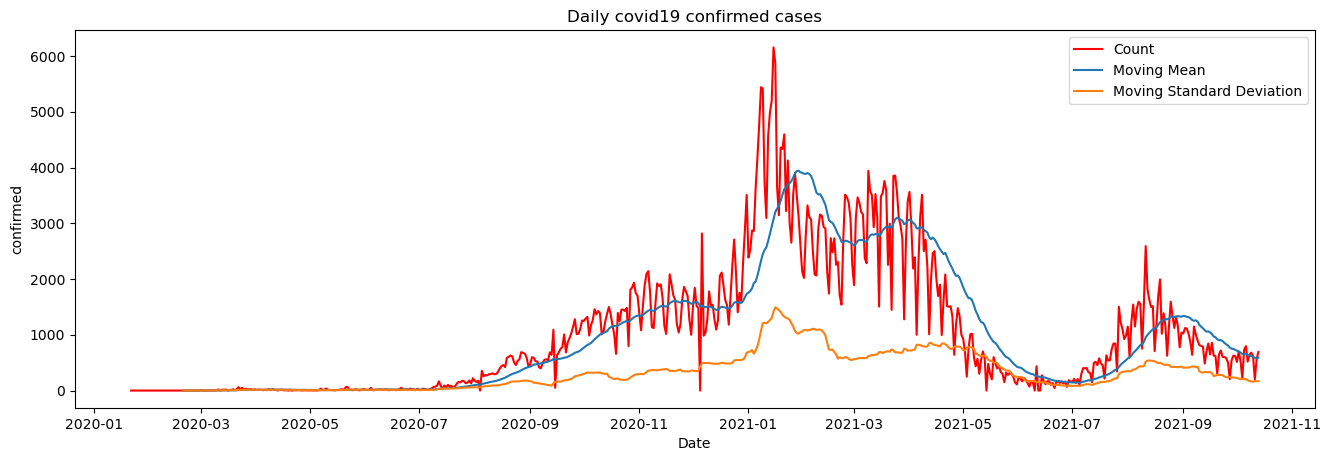

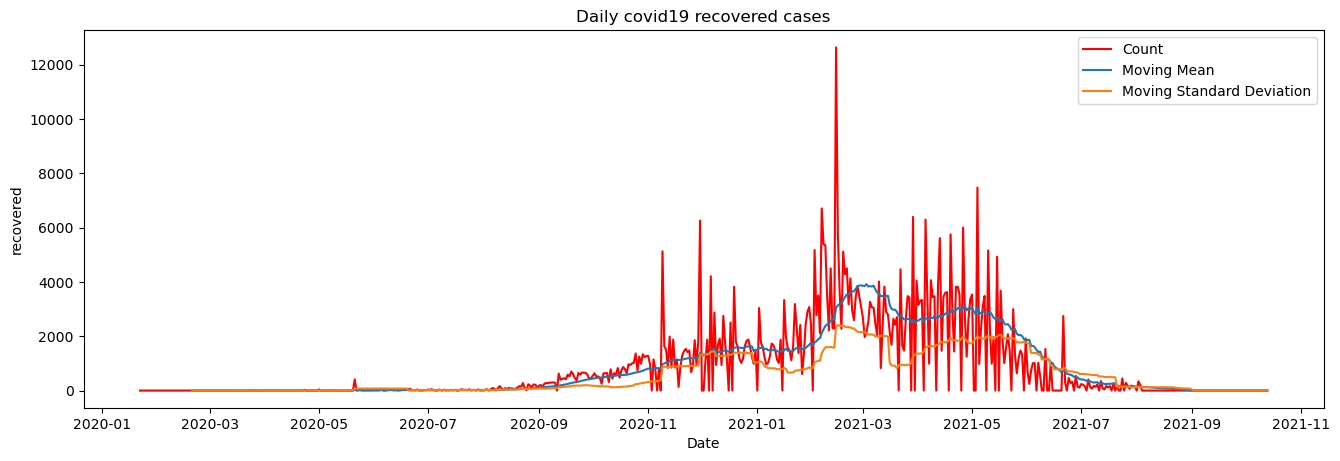

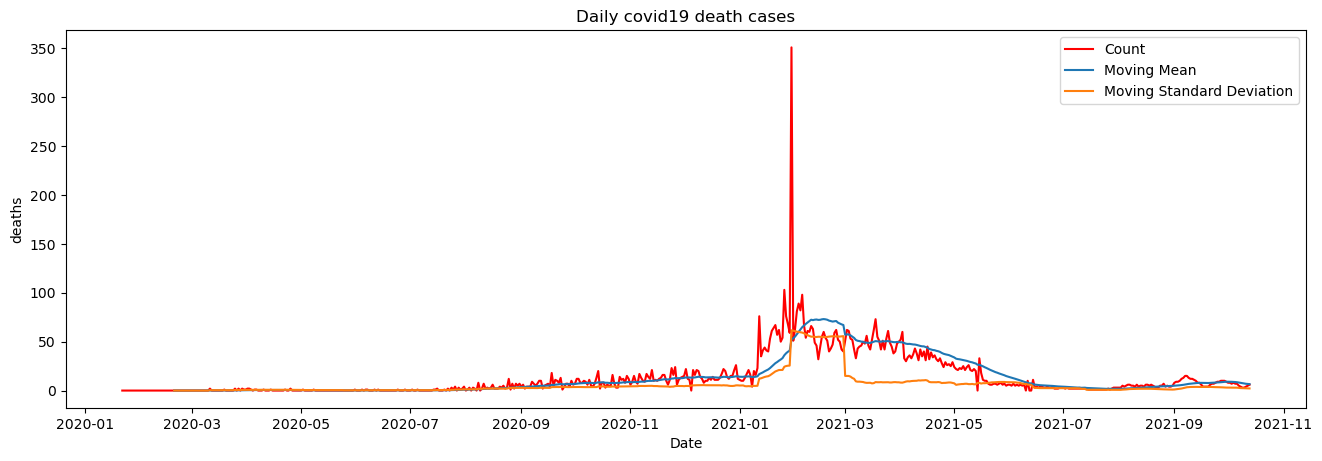

In [11]:
cases = ['confirmed', 'recovered', 'death']
for i, col in enumerate(leb_features.columns):
    plot_df(leb_features, x=leb_features.index, y=leb_features[col],ylabel=col, title='Daily covid19 {} cases'.format(cases[i]))
    

It is obvious from the graphs that all the features form a trend because their moving means and standard deviations are not constant

#### Visualize the results per quarter from 2020-10-01 to 2021-09-01

In [12]:
one_year = leb_features['2020-10-01':'2021-09-01']
one_year = one_year.to_period(freq='Q-SEP')
one_year = one_year.groupby('date').mean().reset_index()
one_year['date'] = ['Q1', 'Q2', 'Q3', 'Q4']
one_year

,date,confirmed,recovered,deaths
0,Q1,1542.054348,1199.934783,11.967391
1,Q2,3187.744444,2696.977778,52.955556
2,Q3,840.285714,1778.571429,17.769231
3,Q4,927.333333,81.206349,3.333333


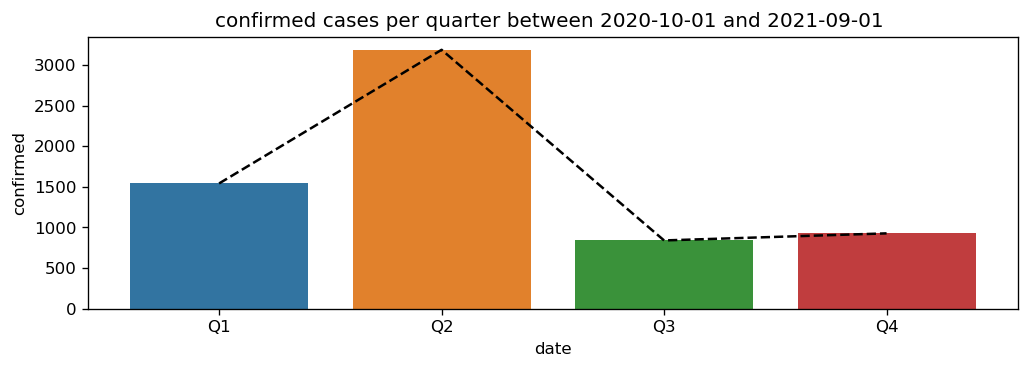

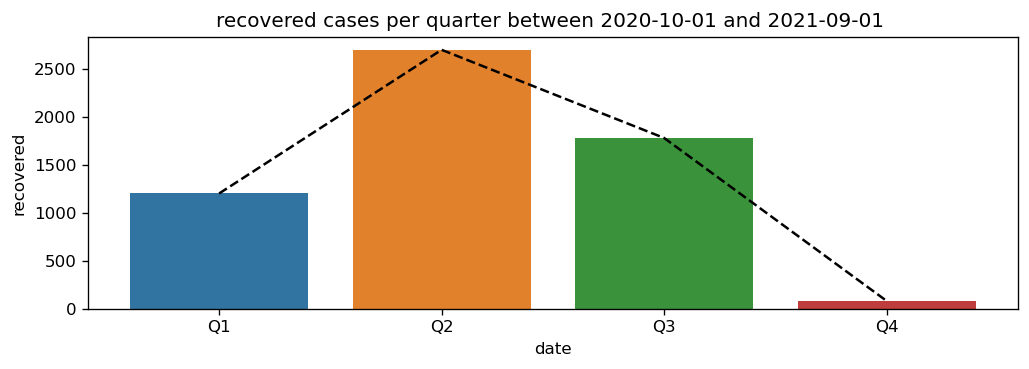

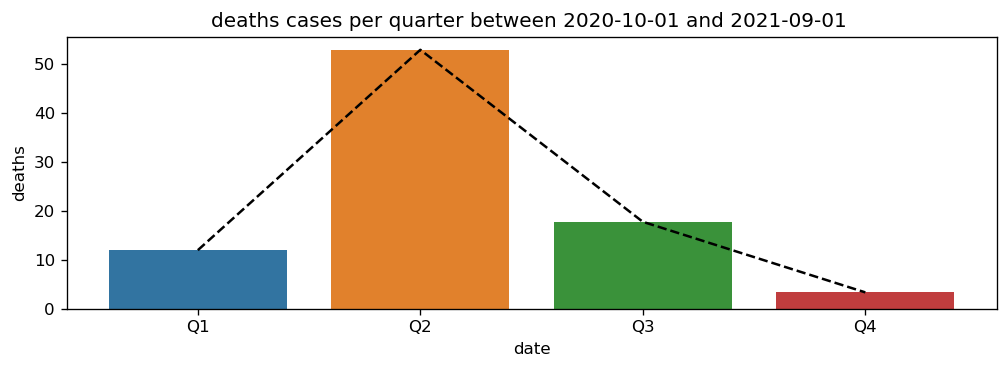

In [13]:
for col in one_year.columns[1:]:
    plt.figure(figsize=(10,3))
    sns.barplot(x='date', y=col, data=one_year)
    plt.title(str(col) + ' cases per quarter between 2020-10-01 and 2021-09-01 ' )
    one_year[col].plot(style='k--')
    plt.show()

There was a critical increase in all the features between Q1 and Q2. This might be due to the holidays which occur at the beginning of Q2 where people visit each other and hangout which makes it more likely to spread COVID-19.

### 3.2. <p id='3-2'> Test if the Series are Stationary </p>

<b> Although the time series models implicitly convert the series to stationary if not, it is good to check how the data is distributed. </b>

The perviously plotted graphs noted that the moving means and standard deviations are not constant implying stationarity, but to be precise, we need further analyses. 

There are several ways to test for stationarity, one approach is to apply statistical tests called 'Unit Roots Tests'. These tests have multiple variations, so I will be using `ADF Test`.

#### ADF Test

<i> H<sub> 0</sub>: The time series possesses a unit root and is non-stationary. </i>

<i> H<sub>1</sub>: The time series is stationary </i>

Reject H<sub>0</sub> if p_values <= 0.05.

In [14]:
def ADF(feature):
    result = adfuller(feature.values, autolag='AIC')
    print(f'ADF Statistic: {result[0]}', end='\n--------------------------------\n')
    print(f'p-value: {result[1]} ', end='\n--------------------------------\n')
    for key, value in result[4].items():
        print('Critial Values:' , end='')
        print(f'   {key}, {value}')

In [15]:
ADF(leb_features['confirmed'])

ADF Statistic: -1.685806650272175
--------------------------------
p-value: 0.43843975430470944 
--------------------------------
Critial Values:   1%, -3.441115625417986
Critial Values:   5%, -2.866289751785392
Critial Values:   10%, -2.56929951625907


In [16]:
ADF(leb_features['recovered'])

ADF Statistic: -1.609751638448515
--------------------------------
p-value: 0.47869329945989314 
--------------------------------
Critial Values:   1%, -3.441115625417986
Critial Values:   5%, -2.866289751785392
Critial Values:   10%, -2.56929951625907


In [17]:
ADF(leb_features['deaths'])

ADF Statistic: -2.090390442231601
--------------------------------
p-value: 0.24839616831221967 
--------------------------------
Critial Values:   1%, -3.440873084361836
Critial Values:   5%, -2.866182929627575
Critial Values:   10%, -2.5692425987220577


<b> ADF Test Findings </b>

After applying the ADF test on the three features undergoing time series analyses, the findings suggest that there is no enough evidence to reject the null hypotheses (p_value > 0.05) , therefore the three features are not stationary.

### 4.1. <p id='4-1'> Split data into train and test </p>

In [18]:
print('Shape of the data sample: ', leb_features.shape)
train = leb_features[0:round(0.8*leb_features.shape[0])]
test = leb_features[len(train):]
print('Train set size: ', len(train))
print('Test set size: ', len(test))

Shape of the data sample:  (631, 3)
Train set size:  505
Test set size:  126


### 4.2. <p id='4-2'>Modelling with AR (auto regressive) model.</p>

The models will be used to predict how the number of cases will change in the coming 20 days.

#### AR model `for confirmed cases`

In [19]:
ar_confirmed = AR(train.confirmed)
ar_model_confirmed = ar_confirmed.fit()
conf_pred = ar_model_confirmed.predict(start=505, end=524)

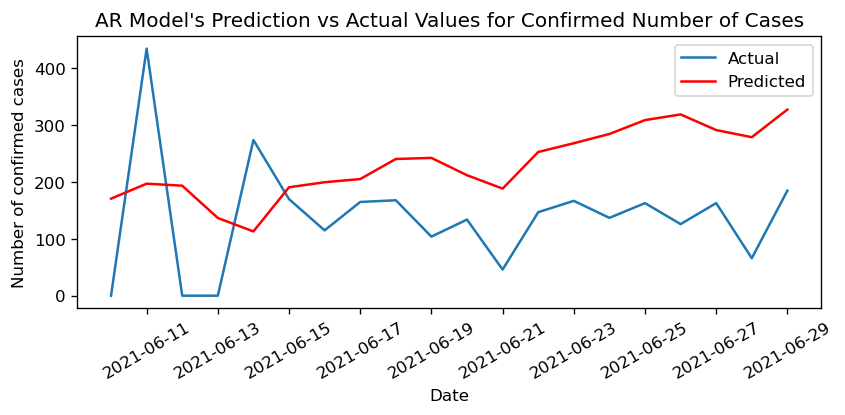

In [20]:
plt.plot(test.confirmed[:20])
plt.plot(conf_pred, color='red')
plt.title("AR Model's Prediction vs Actual Values for Confirmed Number of Cases")
plt.xlabel('Date', )
plt.ylabel('Number of confirmed cases')
plt.legend(['Actual', 'Predicted'])
plt.xticks(rotation=30)
plt.show()

The model doesn't make an accurate representation of the actual data but it reflects whether the actual number of cases will increase or decrease.

#### AR model for `recovered cases`

In [21]:
ar_recovered = AR(train.recovered)
ar_model_recovered = ar_recovered.fit()
pred_recov = ar_model_recovered.predict(start=505, end=524)

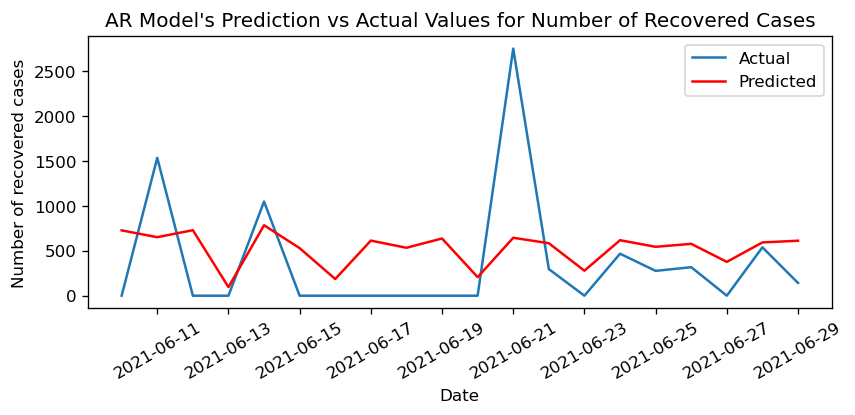

In [22]:
plt.plot(test.recovered[:20])
plt.plot(pred_recov, color='red')
plt.title("AR Model's Prediction vs Actual Values for Number of Recovered Cases")
plt.xlabel('Date')
plt.ylabel('Number of recovered cases')
plt.legend(['Actual', 'Predicted'])
plt.xticks(rotation=30)
plt.show()

The model doesn't make a good representation for all the days, but it reflects whether the actual number of cases will increase or decrease.

#### AR model for `death cases`

In [23]:
ar_death = AR(train.deaths)
ar_model_death = ar_death.fit()
pred_death = ar_model_death.predict(start=505, end=524)

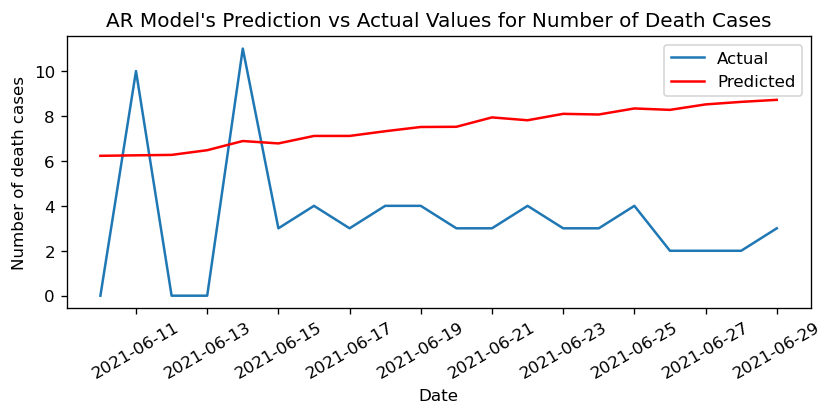

In [24]:
plt.plot(test.deaths[:20])
plt.plot(pred_death, color='red')
plt.title("AR Model's Prediction vs Actual Values for Number of Death Cases")
plt.xlabel('Date')
plt.ylabel('Number of death cases')
plt.legend(['Actual', 'Predicted'])
plt.xticks(rotation=30)
plt.show()

The model reflects that their will not be a significant change in the actual number of cases.

### Conclusion

Despite that the AR models didn't accurately represent the actual values, but they reflected the direction of the actual values in terms of increasing or decreasing which makes them useful for some problems.